In [135]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np 
import tensorflow.keras as keras
import tensorflow as tf

import config

In [137]:
model = load_model('artifacts/training/model.h5')
model.summary()

#last conv layer = 'block5_conv3'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [79]:
img_path= 'artifacts/data_ingestion/Chest-CT-Scan-data/adenocarcinoma/000008 (10).png'
last_conv_layer_name = 'block5_conv3'
classifier_layer_names = ['global_average_pooling2d','dense','dense_1']

In [76]:
def get_image_array(path):
    img = image.load_img(path,target_size=(224,224,3))
    img = image.img_to_array(img) #np.float32
    array = np.expand_dims(img,axis=0)
    return array

print(get_image_array(path=img_path).shape)

(1, 224, 224, 3)


In [144]:
def make_gradcam_heatmap(model,image_array,last_conv_layer_name,classifier_layer_names):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(
        inputs = model.inputs,
        outputs = last_conv_layer.output,
    )
    
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input,x)
    
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(image_array)
        tape.watch(last_conv_layer_output)
        
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = np.argmax(preds[0])
        top_class_channel = preds[:,top_pred_index]
        
    grad = tape.gradient(top_class_channel,last_conv_layer_output)
    pooled_grad = tf.reduce_mean(grad,axis=(0,1,2))
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grad = pooled_grad.numpy()
    for i in range(pooled_grad.shape[-1]):
        last_conv_layer_output[:,:,i] *=pooled_grad[i]
        
    heatmap = np.mean(last_conv_layer_output,axis=-1)
    heatmap = np.maximum(heatmap,0)/np.max(heatmap)
    return heatmap

img= get_image_array('artifacts/data_ingestion/Chest-CT-Scan-data/normal/2.png')
print(make_gradcam_heatmap(image_array=img,
                           model=model,
                           last_conv_layer_name=last_conv_layer_name,
                           classifier_layer_names=classifier_layer_names).shape)
    

(14, 14)


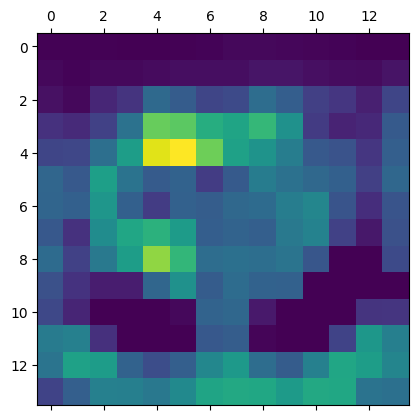

In [166]:
original_img = keras.preprocessing.image.load_img('artifacts/data_ingestion/Chest-CT-Scan-data/adenocarcinoma/000005 (3).png')
original_img = keras.preprocessing.image.img_to_array(original_img)
img =get_image_array('artifacts/data_ingestion/Chest-CT-Scan-data/normal/2.png')

heatmap = make_gradcam_heatmap(image_array=img,
                           model=model,
                           last_conv_layer_name=last_conv_layer_name,
                           classifier_layer_names=classifier_layer_names)
import matplotlib.pyplot as plt

In [177]:
from matplotlib.pyplot import get_cmap as cm
heatmap = np.uint8(255*heatmap)

jet = cm('jet')
jet_color = jet(np.arange(256))[:,:3]
jet_heatmap = jet_color[heatmap]

jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((original_img.shape[1],original_img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap*0.4+original_img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
superimposed_img.save('final.jpeg')

In [172]:
original_img.shape

(243, 397, 3)

In [179]:
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(
    inputs = model.inputs,
    outputs = last_conv_layer.output,
)
last_conv_layer.output.shape

TensorShape([None, 14, 14, 512])

In [181]:
model.inputs

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>]

In [87]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input

for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input,x)

In [89]:
classifier_model.summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 14, 512)]     0         
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 527362 (2.01 MB)
Trainable params: 527362 (2.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
last_conv_layer_model.summary()

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [92]:
image = get_image_array('artifacts/data_ingestion/Chest-CT-Scan-data/normal/2.png')

In [129]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(image)
    tape.watch(last_conv_layer_output)
    
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = np.argmax(preds[0])
    top_class_channel = preds[:,top_pred_index]
    
grad = tape.gradient(top_class_channel,last_conv_layer_output)
pooled_grad = tf.reduce_mean(grad,axis=(0,1,2))
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grad = pooled_grad.numpy()
for i in range(pooled_grad.shape[-1]):
    last_conv_layer_output[:,:,i] *=pooled_grad[i]
    
heatmap = np.mean(last_conv_layer_output,axis=-1)


In [131]:
heatmap.shape

(14, 14)

In [116]:
pooled_grad[1]

-6.9785705e-16

In [94]:
last_conv_layer_ops = last_conv_layer_model.predict(image)

1/1 [==============================] - 0s 467ms/step


In [98]:
preds = classifier_model.predict(last_conv_layer_ops)

1/1 [==============================] - 0s 10ms/step


In [99]:
top_pred_index = np.argmax(preds[0])
top_pred_index


1

In [100]:
top_class_channel = preds[:,top_pred_index]

In [101]:
top_class_channel

array([1.], dtype=float32)